1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, norm, linregress
from scipy.integrate import trapz
import pandas as pd
%matplotlib notebook

In [74]:
x = np.random.normal(loc = 0., scale = 0.5, size = 1000)

<IPython.core.display.Javascript object>


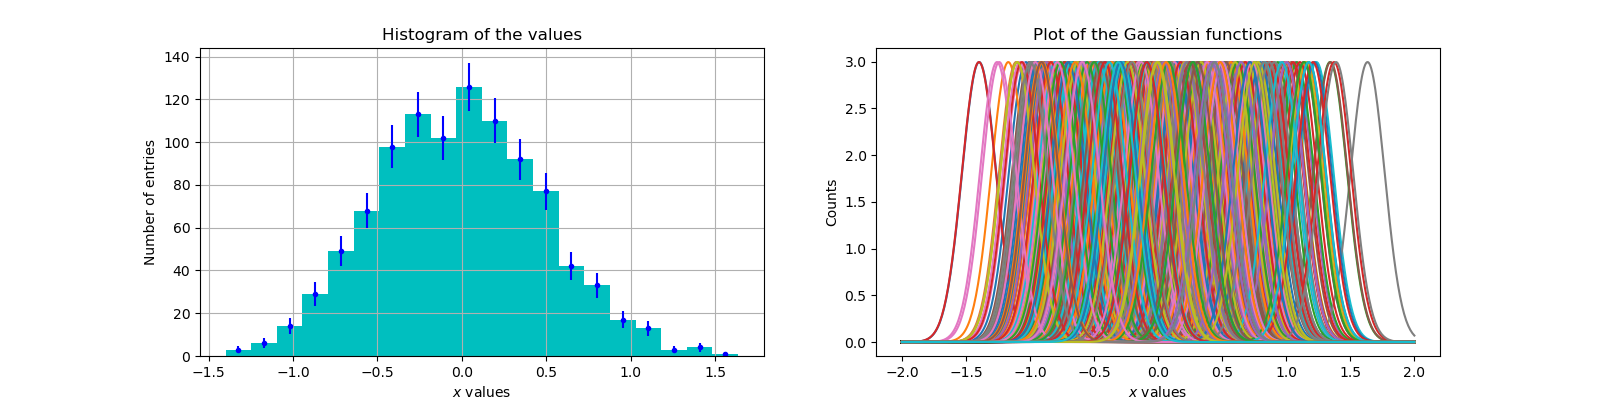

<IPython.core.display.Javascript object>


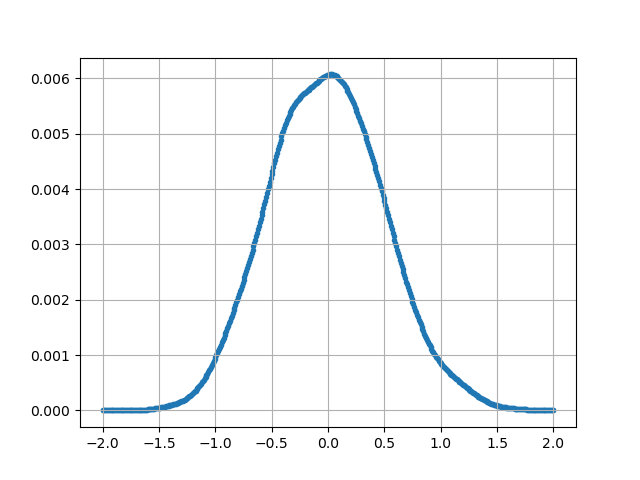

In [75]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(16, 4))
counts, bins, _ = ax1.hist(x, bins = 20, color = 'c')

#First plot

ax1.set_ylabel('Number of entries')
ax1.set_xlabel('$x$ values')
ax1.set_title('Histogram of the values')
ax1.grid()

#Shift of the bars to the middle of the bin
shift = bins[1] - bins[0]
bins += shift/2

ax1.errorbar(bins[:len(bins) - 1], counts, yerr = np.sqrt(counts), fmt = 'b.')

#Second plot

std = 1.06*0.5*len(x)**(-1/5)

N = 500
a = np.linspace(-2, 2, N)


gaussians = np.zeros((len(x),N))

i = 0
for value in x:
    func = norm.pdf(a, loc = value, scale = std)
    gaussians[i, :] = func 
    ax2.plot(a, func)
    i += 1

ax2.set_xlabel('$x$ values')
ax2.set_title('Plot of the Gaussian functions')
ax2.set_ylabel('Counts')

gaussians_sum = np.zeros(len(a))
for i in range(0, len(a)):
    gaussians_sum[i] = np.sum(gaussians[:,i])

integral = trapz(gaussians_sum)

plt.figure()
plt.scatter(a, gaussians_sum/integral, marker = '.')
plt.grid()

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

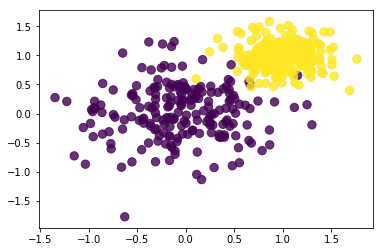

In [78]:
#! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

<IPython.core.display.Javascript object>


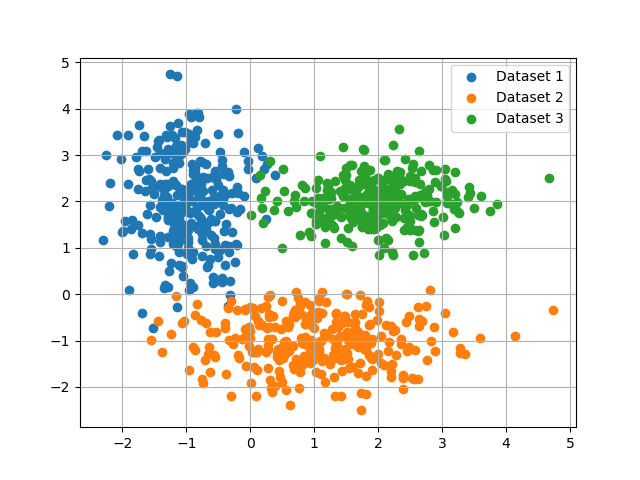

In [79]:
def gauss_gen(x, y, stdx, stdy):
    r = np.random.normal(loc = x, scale = stdx, size = 300)
    s = np.random.normal(loc = y, scale = stdy, size = 300)
    return (r, s)

x1, y1 = gauss_gen(-1, 2, 0.5, 1)

x2, y2 = gauss_gen(1, -1, 1, 0.5)

x3, y3 = gauss_gen(2, 2, 0.7, 0.5)

plt.figure()

plt.scatter(x1, y1, label = 'Dataset 1')
plt.scatter(x2, y2, label = 'Dataset 2')
plt.scatter(x3, y3, label = 'Dataset 3')

plt.legend()
plt.grid()

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [81]:
#!wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy

In [82]:
import seaborn as sns

<IPython.core.display.Javascript object>


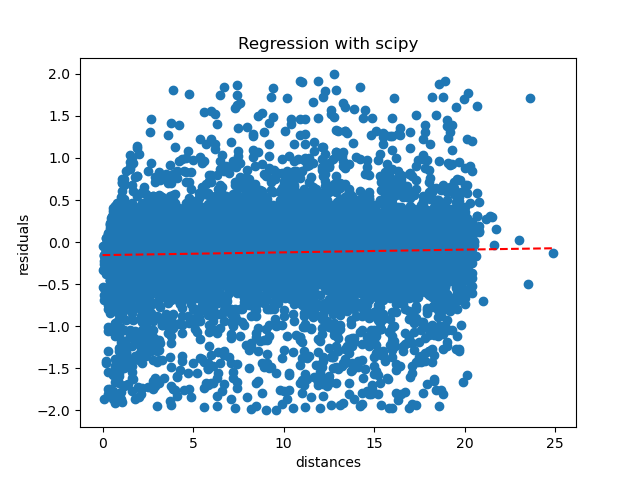

Text(0.5, 0, 'distances')

In [102]:
filename = 'residuals_261.npy'

data = np.load(filename, allow_pickle = True)
data = data.item()
data = pd.DataFrame(data)

data = data[abs(data['residuals']) <= 2]

m, q, _, _, _ = linregress(data['distances'], data['residuals'])

plt.figure()
y = data['residuals']
x = data['distances']
plt.title('Regression with scipy')
plt.scatter(x, y)
a = np.linspace(min(x), max(x), 100)
plt.plot(a, a*m + q, 'r--')
plt.ylabel('residuals')
plt.xlabel('distances')

<IPython.core.display.Javascript object>


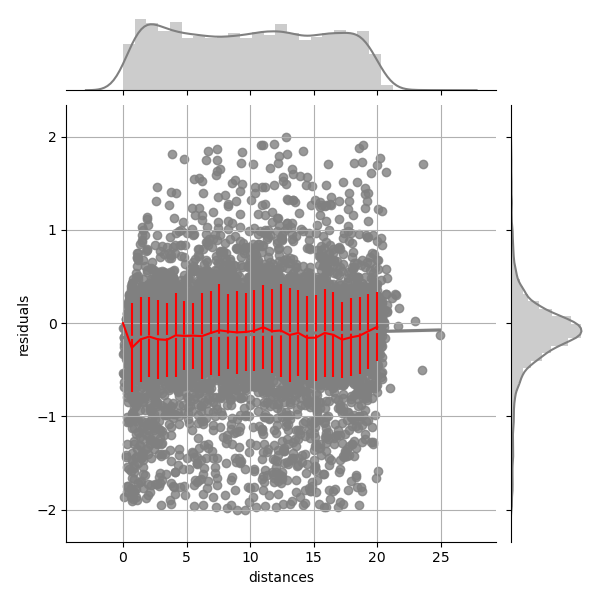

In [100]:
data_filtered = data[data['distances'] <= 20.].sort_values(by = 'distances')

nbins = 30
y = np.zeros(nbins)
erry = np.zeros(nbins)

x = np.linspace(0,20,nbins)

for i in range(1,nbins):
    df1 = data_filtered[data_filtered['distances'] > x[i-1]]
    df2 = df1[df1['distances'] <= x[i]]
    y[i] = df2['residuals'].mean()
    erry[i] = df2['residuals'].std()



sns.jointplot(x = 'distances', y = 'residuals', data = data, kind = 'reg', color = 'grey' )
plt.errorbar(x, y, yerr = erry, color = 'red')
plt.grid()
